<a href="https://colab.research.google.com/github/yemikifouly/dog-breeds-classifier/blob/master/dog_breeds_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classifying Dog Breeds

The goal of this project is to identify the breeds of dogs given their images. Besides doing this, the notebook also contains contain for the cases where the images given the model are images of a human being. In which case the code is supposed to return the dog breed the human most closely resembles.

In [0]:
# import statements
from tqdm import tqdm

import os

import numpy as np

from glob import glob

import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models

from PIL import Image
import torchvision.transforms as transforms
# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline
import matplotlib.pyplot as plt

import random

import re

In [2]:
use_gpu = torch.cuda.is_available()
print('Using gpu...' if use_gpu else 'Using cpu...')

Using gpu...


## Step 0: Loading the data

Loading and unzipping the data.

In [0]:
!wget -q 'https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip'

In [0]:
!unzip dogImages.zip

## Step 1: Checking content of the files


Check the content of the loaded folders.

In [21]:
# load filenames for human and dog images
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total dog images.' % len(dog_files))

There are 8351 total dog images.


In [0]:
def retrieve_name(img_path):
    pattern = r'.+/(\w+)_\d+.jpg'
    match = re.findall(pattern, img_path, re.I)[0]
    match = match.replace('_', ' ').title()
    return match

In [0]:
def display_image(img_path):
    img = Image.open(img_path)
    imgplot = plt.imshow(img)
    plt.axis('off')
    title = retrieve_name(img_path)
    plt.title(title)

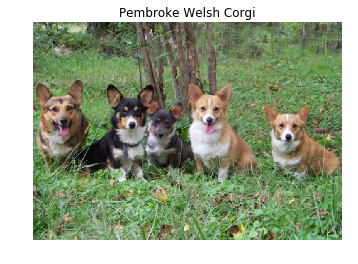

In [27]:
display_image(random.choice(dog_files))

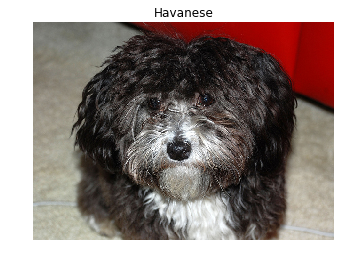

In [28]:
display_image(random.choice(dog_files))

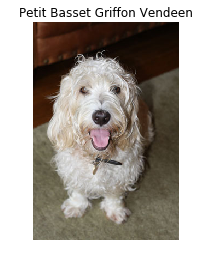

In [29]:
display_image(random.choice(dog_files))

###1.b: Preprocessing the images

In [0]:
def preprocess_img(image):
    normalize = transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                )
    
    preprocess = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    normalize
                 ])
    
    return preprocess(image)

## Define Dataloaders

In [0]:
batch_size, num_workers = 20, 0

train_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                             [0.229, 0.224, 0.225])
                                      ])

valid_and_test_transforms = transforms.Compose([transforms.Resize(256),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406],
                                                                     [0.229, 0.224, 0.225])
                                               ])

# Get the data folders
train_data = datasets.ImageFolder('dogImages/train', transform=train_transforms)

valid_data = datasets.ImageFolder('dogImages/valid', 
                                      transform=valid_and_test_transforms)

test_data = datasets.ImageFolder('dogImages/test', 
                                      transform=valid_and_test_transforms)

data_dict = {'train':train_data,
             'valid':valid_data,
             'test':test_data}

# Define the loaders
loaders = {name:torch.utils.data.DataLoader(folder, batch_size=batch_size,
                shuffle=True, num_workers=num_workers) for name, folder in data_dict.items()}

In [35]:
num_classes = len(train_data.classes)
num_classes

133

## Transfer Learning